<a href="https://colab.research.google.com/github/SanchayanDutta/ICLR-2025/blob/main/Mixture_of_Experts_OOD_Final_TrainableGamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def attention(P, Q, Z, activation=None):
    B = Z.shape[0]
    N = Z.shape[1] - 1
    d = Z.shape[2] - 1

    # Expand P and Q into (d+1) x (d+1)
    P_full = torch.cat([P, torch.zeros(1, d).to(device)], dim=0)
    P_full = torch.cat([P_full, torch.zeros(d+1, 1).to(device)], dim=1)
    P_full[d, d] = 1.0  # extra dimension for the label

    Q_full = torch.cat([Q, torch.zeros(1, d).to(device)], dim=0)
    Q_full = torch.cat([Q_full, torch.zeros(d+1, 1).to(device)], dim=1)

    # A is eye(N+1) except the bottom-right corner is 0
    A = torch.eye(N+1).to(device)
    A[N, N] = 0.0

    # Attn shape: [B, N+1, N+1]
    Attn = torch.einsum('BNi, ij, BMj -> BNM', (Z, Q_full, Z))
    if activation is not None:
        Attn = activation(Attn)

    # key shape: [B, N+1, d+1]
    key = torch.einsum('ij, BNj -> BNi', (P_full, Z))

    # Output shape: [B, N+1, d+1]
    Output = torch.einsum('BNM, ML, BLi -> BNi', (Attn, A, key))
    return Output / N

class Transformer_F(nn.Module):
    def __init__(self, n_layer, n_head, N, d, var, run_mode, head_choice=None):
        super().__init__()

        # allparam: [n_layer, n_head, 2, d, d]
        #   - The "2" dimension is for (P, Q).
        self.register_parameter(
            'allparam',
            nn.Parameter(torch.zeros(n_layer, n_head, 2, d, d))
        )
        # gamma: [n_layer, n_head, 1, N+1, d+1]
        self.gamma = nn.Parameter(torch.ones(n_layer, n_head, 1, N+1, d+1))

        with torch.no_grad():
            self.allparam.normal_(0, var)  # initialize allparam

        self.n_layer = n_layer
        self.n_head = n_head
        self.run_mode = run_mode
        self.head_choice = head_choice  # used if run_mode=0

        # Gating mechanism: one gating parameter per head.
        # We let it be trainable only if run_mode==1
        self.gate = nn.Parameter(
            torch.zeros(n_head), requires_grad=(run_mode == 1)
        )

    def forward(self, Z):
        """
        Z has shape [B, N+1, d+1].
          - The last entry in d+1 is typically the label dimension.
        run_mode=0 => single-head usage, pick one head (head_choice).
        run_mode=1 => multi-head usage with gating at test-time.
        """
        B, N, d = Z.shape[0], Z.shape[1] - 1, Z.shape[2] - 1

        # If run_mode=1, precompute the gating weights (for all heads)
        if self.run_mode == 1:
            # e.g. softmax if you want strictly positive + sum=1
            # gate_weights_expanded = F.softmax(self.gate, dim=-1).view(-1, 1, 1, 1)
            gate_weights_expanded = self.gate.view(-1, 1, 1, 1)

        # --------------------------
        # run_mode = 0 (single head)
        # --------------------------
        if self.run_mode == 0:
            # If no head_choice is provided, default to 0
            chosen_head = self.head_choice if self.head_choice is not None else 0

            # Allocate R and T once, outside the layer loop
            # R[i] and T[i] each: [B, N+1, d+1]
            R = [torch.zeros_like(Z) for _ in range(self.n_layer)]
            T = [torch.zeros_like(Z) for _ in range(self.n_layer)]

            for i in range(self.n_layer):
                # Save the old Z before the update
                Zi = Z.clone()

                Pij = self.allparam[i, chosen_head, 0, :, :]  # [d, d]
                Qij = self.allparam[i, chosen_head, 1, :, :]  # [d, d]

                R[i] = attention(Pij, Qij, Zi)  # => [B, N+1, d+1]

                # Sum up older layers R[k], weighted by gamma[k]
                T[i] = R[i] + sum(
                    R[k] * self.gamma[k, chosen_head, :, :, :].expand(B, N+1, d+1)
                    for k in range(i)
                )

                # Update Z
                Z = Zi + T[i]

            return Z

        # --------------------------
        # run_mode = 1 (multi-head)
        # --------------------------
        elif self.run_mode == 1:
            # We'll store R[i][j], T[i][j] for each layer i, head j
            # R[i][j] => [B, N+1, d+1]
            R = [
                [torch.zeros_like(Z) for _ in range(self.n_head)]
                for _ in range(self.n_layer)
            ]
            T = [
                [torch.zeros_like(Z) for _ in range(self.n_head)]
                for _ in range(self.n_layer)
            ]

            for i in range(self.n_layer):
                Zi = Z.clone()
                head_attentions = []

                for j in range(self.n_head):
                    Pij = self.allparam[i, j, 0, :, :]  # [d, d]
                    Qij = self.allparam[i, j, 1, :, :]  # [d, d]

                    # Compute attention for layer i, head j
                    R[i][j] = attention(Pij, Qij, Zi)

                    # Sum up older layers R[k][j], weighted by gamma[k, j]
                    T[i][j] = R[i][j] + sum(
                        R[k][j] * self.gamma[k, j, :, :, :].expand(B, N+1, d+1)
                        for k in range(i)
                    )

                    head_attentions.append(T[i][j])

                # Stack heads into shape [n_head, B, N+1, d+1]
                head_attentions = torch.stack(head_attentions, dim=0)

                # Weighted sum across heads => [B, N+1, d+1]
                attention_sum = (head_attentions * gate_weights_expanded).sum(dim=0)

                # Update Z
                Z = Zi + attention_sum

            return Z

        else:
            raise ValueError("Invalid run_mode. Should be 0 or 1.")

    def zero_p(self):
        # If you want to zero out P for each layer/head
        with torch.no_grad():
            for i in range(self.n_layer):
                for j in range(self.n_head):
                    self.allparam[i, j, 0, :, :].zero_()

def in_context_loss(model, Z, y):
    N = Z.shape[1] - 1
    d = Z.shape[2] - 1
    output = model(Z)  # shape [B, N+1, d+1]

    # The "test" prediction often is output[:, N, d]
    # y has shape [B] or [B, 1], so we do output[:,N,d] + y
    diff = output[:, N, d] + y
    loss = (diff ** 2).mean()
    return loss

# --------------------------------------------------------------------
# Data-generation functions remain the same:
# --------------------------------------------------------------------

def generate_data(mode='normal',
                  N=20,
                  d=1,
                  B=1000,
                  shape_k=0.1,
                  U=None,
                  D=None,
                  data_variance=1.0,
                  data_mean=0.0):
    """
    mode: 'normal', 'sphere', 'gamma', 'relu', or 'mlp'
    N, d, B: as before
    data_variance: variance of the Gaussian
    data_mean: mean of the Gaussian
    """
    std = math.sqrt(data_variance)
    W = torch.FloatTensor(B, d).normal_(data_mean, std).to(device)
    X = torch.FloatTensor(B, N, d).normal_(data_mean, std).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(data_mean, std).to(device)

    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W = torch.mm(W, torch.inverse(D))
        W = torch.mm(W, U.t())

    if mode == 'sphere':
        X.div_(X.norm(p=2, dim=2, keepdim=True))
        X_test.div_(X_test.norm(p=2, dim=2, keepdim=True))
    elif mode == 'gamma':
        gamma_scales = np.random.gamma(shape=shape_k,
                                       scale=(10 / shape_k)**0.5,
                                       size=[B, N])
        gamma_scales = torch.Tensor(gamma_scales).to(device).sqrt()
        gamma_test_scales = np.random.gamma(shape=shape_k,
                                            scale=(10 / shape_k)**0.5,
                                            size=[B, 1])
        gamma_test_scales = torch.Tensor(gamma_test_scales).to(device).sqrt()

        X.div_(X.norm(p=2, dim=2, keepdim=True))
        X_test.div_(X_test.norm(p=2, dim=2, keepdim=True))
        X.mul_(gamma_scales.unsqueeze(-1))
        X_test.mul_(gamma_test_scales.unsqueeze(-1))

    elif mode == 'normal':
        pass  # Already uses data_mean in normal_.
    elif mode == 'relu':
        return generate_data_relu(N=N, d=d, B=B, hidden_dim=d)
    elif mode == 'mlp':
        return generate_data_mlp(N=N, d=d, B=B, hidden_dim=d)
    else:
        raise ValueError(f"Unknown mode: {mode}")

    # If U and D are provided, apply them to X, X_test
    if U is not None:
        X = torch.einsum('ij, jk, BNk -> BNi', (U, D, X))
        X_test = torch.einsum('ij, jk, BNk -> BNi', (U, D, X_test))

    # Standard label generation
    y = torch.einsum('bi,bni->bn', (W, X)).unsqueeze(2)  # shape [B, N, 1]
    y_zero = torch.zeros(B, 1, 1).to(device)             # shape [B, 1, 1]
    y_test = torch.einsum('bi,bni->bn', (W, X_test)).squeeze(1)  # shape [B]

    # Combine data and label
    X_comb = torch.cat([X, X_test], dim=1)  # [B, N+1, d]
    y_comb = torch.cat([y, y_zero], dim=1)  # [B, N+1, 1]
    Z = torch.cat([X_comb, y_comb], dim=2)  # [B, N+1, d+1]

    return Z.to(device), y_test.to(device)

def generate_data_inplace(Z, U=None, D=None):
    B = Z.shape[0]
    N = Z.shape[1] - 1
    d = Z.shape[2] - 1

    X = Z[:, :, 0:-1]
    X.normal_(0, 1).to(device)
    W = torch.FloatTensor(B, d).normal_(0, 1).to(device)

    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W = torch.mm(W, torch.inverse(D))
        W = torch.mm(W, U.t())
        Z[:, :, 0:-1] = torch.einsum('ij, jk, BNk -> BNi', (U, D, X))

    Z[:, :, -1] = torch.einsum('bi,bni->bn', (W, Z[:, :, 0:-1]))
    y_test = Z[:, -1, -1].detach().clone()
    Z[:, -1, -1].zero_()
    return Z.to(device), y_test.to(device)

def generate_data_sine(N=10, B=1000):
    a = torch.FloatTensor(B).uniform_(0.1, 5).to(device)
    p = torch.FloatTensor(B).uniform_(0, math.pi).to(device)

    X = torch.FloatTensor(B, N).uniform_(-5, 5).to(device)
    Y = a.unsqueeze(1) * torch.sin(p.unsqueeze(1) + X)

    X = X.unsqueeze(-1)
    Y = Y.unsqueeze(-1)

    return X, Y

def generate_data_relu(mode='normal', N=20, d=1, B=1000, shape_k=0.1, U=None, D=None, hidden_dim=100):
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1)
    ).to(device)
    model[0].weight.data.normal_(0, 0.1)
    model[2].weight.data.normal_(0, 0.1)

    # [B*N, 1] => reshape to [B, N, 1]
    y = model(X.view(-1, d)).view(B, N, 1)
    y_test = model(X_test.view(-1, d)).view(B, 1).squeeze(1)

    y_zero = torch.zeros(B, 1, 1).to(device)
    X_comb = torch.cat([X, X_test], dim=1)
    y_comb = torch.cat([y, y_zero], dim=1)
    Z = torch.cat([X_comb, y_comb], dim=2)
    return Z, y_test

def generate_data_mlp(N=20, d=1, B=1000, hidden_dim=100):
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, d)
    ).to(device)
    model[0].weight.data.normal_(0, 1)
    model[2].weight.data.normal_(0, 1)

    X_MLP = model(X.view(-1, d)).view(B, N, d)
    X_test_MLP = model(X_test.view(-1, d)).view(B, 1, d)

    W = torch.FloatTensor(B, d).normal_(0, 1).to(device)
    y = torch.einsum('bi,bni->bn', (W, X_MLP)).unsqueeze(2)
    y_zero = torch.zeros(B, 1, 1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test_MLP)).squeeze(1)

    X_comb = torch.cat([X_MLP, X_test_MLP], dim=1)
    y_comb = torch.cat([y, y_zero], dim=1)
    Z = torch.cat([X_comb, y_comb], dim=2)
    return Z, y_test

In [2]:
!cp /content/linear_transformer.py /content/

cp: '/content/linear_transformer.py' and '/content/linear_transformer.py' are the same file


In [3]:
import linear_transformer

In [4]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np
import math

##############################################################################################################
# Trains a linear Transformer with 1,2,3,4 layers
# Plots the test loss of trained Transformer against 1,2,3,4 steps of gradient descent (with and without preconditioning)
##############################################################################################################

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
# import the model and some useful functions
from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
cur_dir = 'log'
os.makedirs(cur_dir, exist_ok=True)
#f = open(cur_dir + '/rotation.log', "a", 1)
#sys.stdout = f

In [5]:
# Set up problem parameters

lr = 0.01
clip_r = 0.01
alg = 'adam'
mode = 'normal'

n_layer = 4  # number of layers of transformer
N = 20     # context length
d = 5        # dimension


n_head = 3  # 1-headed attention
B = 1000  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates
max_iters = 10  # Number of Iterations to run
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 100

# a convenience function for taking a step and clipping
def clip_and_step(allparam, optimizer, clip_r = None):
    norm_p=None
    grad_all = allparam.grad
    if clip_r is not None:
        for l in range(grad_all.shape[0]):
            for h in range(grad_all.shape[1]):
                for t in range(grad_all.shape[2]):
                    norm_p = grad_all[l,h,t,:,:].norm().item()
                    if norm_p > clip_r:
                        grad_all[l,h,t,:,:].mul_(clip_r/norm_p)
    optimizer.step()
    return norm_p

#format for saving run data
filename_format = '/variable_L_hist_{}_{}_{}.pth'
n_layers = [1,2,3,4]  # number of layers of transformer
seeds=[0,1,2,3,4]
keys = []
for s in seeds:
    for n_layer in n_layers:
        keys.append((s,n_layer,))

In [ ]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Trains allparam and gamma for each head in run_mode=0
# - Combines them into a single run_mode=1 model
# - Fine-tunes gating (and optionally gamma) at test-time
########################################################

loss_dict05 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [1, 2, 3]  # Each head is trained on a different Gaussian variance
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict05[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters in two lists:
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(
                n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U, D, data_variance=data_variance
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train allparam + gamma for this head
            optimizer_head = torch.optim.Adam(
                [head_model.allparam, head_model.gamma], lr=lr
            )
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()

            # allparam: [n_layer, n_head, 2, d, d]
            # gamma:    [n_layer, n_head, 1, N+1, d+1]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head’s part of allparam and gamma
        # from the individually trained heads
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        #         (Optionally also gamma)
        # ----------------------------------------------
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 0.5)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        # Typically we freeze allparam & gamma, train only gating
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        # If you want to fine-tune gamma as well:
        # model.gamma.requires_grad = True  # <--- optional

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute final test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict05[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict05 will contain
# the logged test losses for each seed and layer configuration.

In [ ]:
loss_dict05

{(0,): tensor([-0.87, -1.48, -1.71, -2.14])}

In [ ]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Trains allparam and gamma for each head in run_mode=0
# - Combines them into a single run_mode=1 model
# - Fine-tunes gating (and optionally gamma) at test-time
########################################################

loss_dict1 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 1 head:
n_head = 1
variances = [1]  # Each head is trained on a different Gaussian variance
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict1[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters in two lists:
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(
                n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U, D, data_variance=data_variance
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train allparam + gamma for this head
            optimizer_head = torch.optim.Adam(
                [head_model.allparam, head_model.gamma], lr=lr
            )
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()

            # allparam: [n_layer, n_head, 2, d, d]
            # gamma:    [n_layer, n_head, 1, N+1, d+1]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head’s part of allparam and gamma
        # from the individually trained heads
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        #         (Optionally also gamma)
        # ----------------------------------------------
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 1)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        # Typically we freeze allparam & gamma, train only gating
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        # If you want to fine-tune gamma as well:
        # model.gamma.requires_grad = True  # <--- optional

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 1000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute final test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict1[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict05 will contain
# the logged test losses for each seed and layer configuration.

In [ ]:
loss_dict1

{(0,): tensor([ 0.67, -0.43, -0.96, -1.19])}

In [ ]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Trains allparam and gamma for each head in run_mode=0
# - Combines them into a single run_mode=1 model
# - Fine-tunes gating (and optionally gamma) at test-time
########################################################

loss_dict15 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [1, 2, 3]  # Each head is trained on a different Gaussian variance
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict15[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters in two lists:
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(
                n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U, D, data_variance=data_variance
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train allparam + gamma for this head
            optimizer_head = torch.optim.Adam(
                [head_model.allparam, head_model.gamma], lr=lr
            )
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()

            # allparam: [n_layer, n_head, 2, d, d]
            # gamma:    [n_layer, n_head, 1, N+1, d+1]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head’s part of allparam and gamma
        # from the individually trained heads
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        #         (Optionally also gamma)
        # ----------------------------------------------
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 1.5)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        # Typically we freeze allparam & gamma, train only gating
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        # If you want to fine-tune gamma as well:
        # model.gamma.requires_grad = True  # <--- optional

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute final test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict15[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict05 will contain
# the logged test losses for each seed and layer configuration.

In [ ]:
loss_dict15

{(0,): tensor([ 1.12, -0.17, -0.65, -0.74])}

In [ ]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Trains allparam and gamma for each head in run_mode=0
# - Combines them into a single run_mode=1 model
# - Fine-tunes gating (and optionally gamma) at test-time
########################################################

loss_dict2 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 1 head:
n_head = 1
variances = [2]  # Each head is trained on a different Gaussian variance
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict2[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters in two lists:
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(
                n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U, D, data_variance=data_variance
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train allparam + gamma for this head
            optimizer_head = torch.optim.Adam(
                [head_model.allparam, head_model.gamma], lr=lr
            )
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()

            # allparam: [n_layer, n_head, 2, d, d]
            # gamma:    [n_layer, n_head, 1, N+1, d+1]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head’s part of allparam and gamma
        # from the individually trained heads
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        #         (Optionally also gamma)
        # ----------------------------------------------
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 2)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        # Typically we freeze allparam & gamma, train only gating
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        # If you want to fine-tune gamma as well:
        # model.gamma.requires_grad = True  # <--- optional

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 1000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute final test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict2[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict05 will contain
# the logged test losses for each seed and layer configuration.

In [ ]:
loss_dict2

{(0,): tensor([ 1.82,  0.61,  0.16, -0.42])}

In [ ]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Trains allparam and gamma for each head in run_mode=0
# - Combines them into a single run_mode=1 model
# - Fine-tunes gating (and optionally gamma) at test-time
########################################################

loss_dict25 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [1, 2, 3]  # Each head is trained on a different Gaussian variance
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict25[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters in two lists:
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(
                n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U, D, data_variance=data_variance
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train allparam + gamma for this head
            optimizer_head = torch.optim.Adam(
                [head_model.allparam, head_model.gamma], lr=lr
            )
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()

            # allparam: [n_layer, n_head, 2, d, d]
            # gamma:    [n_layer, n_head, 1, N+1, d+1]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head’s part of allparam and gamma
        # from the individually trained heads
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        #         (Optionally also gamma)
        # ----------------------------------------------
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 2.5)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        # Typically we freeze allparam & gamma, train only gating
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        # If you want to fine-tune gamma as well:
        # model.gamma.requires_grad = True  # <--- optional

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute final test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict25[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict05 will contain
# the logged test losses for each seed and layer configuration.

In [ ]:
loss_dict25

{(0,): tensor([2.14, 0.84, 0.36, 0.12])}

In [ ]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Trains allparam and gamma for each head in run_mode=0
# - Combines them into a single run_mode=1 model
# - Fine-tunes gating (and optionally gamma) at test-time
########################################################

loss_dict3 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 1 head:
n_head = 1
variances = [3]  # Each head is trained on a different Gaussian variance
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict3[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters in two lists:
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(
                n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U, D, data_variance=data_variance
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train allparam + gamma for this head
            optimizer_head = torch.optim.Adam(
                [head_model.allparam, head_model.gamma], lr=lr
            )
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()

            # allparam: [n_layer, n_head, 2, d, d]
            # gamma:    [n_layer, n_head, 1, N+1, d+1]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head’s part of allparam and gamma
        # from the individually trained heads
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        #         (Optionally also gamma)
        # ----------------------------------------------
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 3)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        # Typically we freeze allparam & gamma, train only gating
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        # If you want to fine-tune gamma as well:
        # model.gamma.requires_grad = True  # <--- optional

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 1000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute final test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict3[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict05 will contain
# the logged test losses for each seed and layer configuration.

In [ ]:
loss_dict3

{(0,): tensor([2.52, 1.17, 0.75, 0.10])}

In [ ]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Trains allparam and gamma for each head in run_mode=0
# - Combines them into a single run_mode=1 model
# - Fine-tunes gating (and optionally gamma) at test-time
########################################################

loss_dict35 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [1, 2, 3]  # Each head is trained on a different Gaussian variance
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict35[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters in two lists:
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(
                n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U, D, data_variance=data_variance
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train allparam + gamma for this head
            optimizer_head = torch.optim.Adam(
                [head_model.allparam, head_model.gamma], lr=lr
            )
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()

            # allparam: [n_layer, n_head, 2, d, d]
            # gamma:    [n_layer, n_head, 1, N+1, d+1]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head’s part of allparam and gamma
        # from the individually trained heads
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        #         (Optionally also gamma)
        # ----------------------------------------------
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 3.5)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        # Typically we freeze allparam & gamma, train only gating
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        # If you want to fine-tune gamma as well:
        # model.gamma.requires_grad = True  # <--- optional

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute final test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict35[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict05 will contain
# the logged test losses for each seed and layer configuration.

In [ ]:
loss_dict35

{(0,): tensor([2.81, 1.52, 1.04, 0.79])}

<ipython-input-26-6e36e8c2f879>:17: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std05 = torch.std(losses05, axis=0) / 10
<ipython-input-26-6e36e8c2f879>:33: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std1 = torch.std(losses1, axis=0) / 10
<ipython-input-26-6e36e8c2f879>:50: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std15 = torch.std(losses15, axis=0) / 10
<ipython-input-26-6e36e8c2f879>:66: UserWarning: std(): degrees of freedom is <= 0. Correc

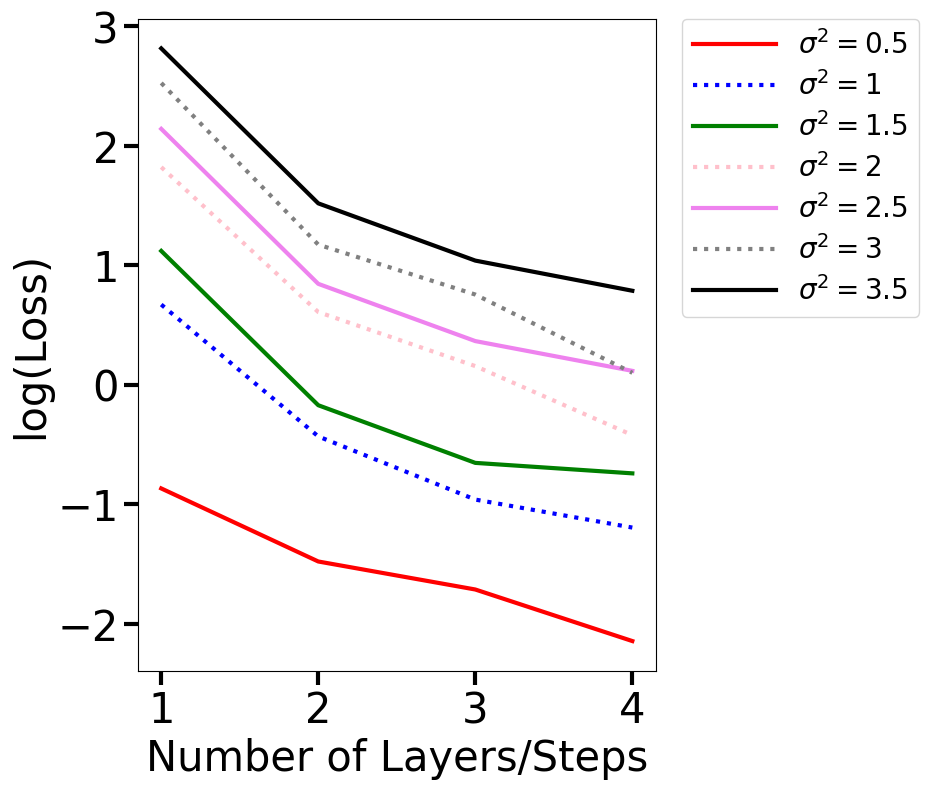

In [ ]:
####################################
# plot final test loss against N
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

# Increase the width of the figure (e.g., 12 inches wide, 8 inches tall)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot for variance = 0.5
losses05 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict05.keys()
for idx, key in enumerate(keys):
    losses05[idx, :] = loss_dict05[key]
losses_mean05 = torch.mean(losses05, axis=0)
losses_std05 = torch.std(losses05, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean05,
    color='red',
    lw=3,
    label=r'$\sigma^2 = 0.5$'
)

# Plot for variance = 1 (make dotted)
losses1 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict1.keys()
for idx, key in enumerate(keys):
    losses1[idx, :] = loss_dict1[key]
losses_mean1 = torch.mean(losses1, axis=0)
losses_std1 = torch.std(losses1, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean1,
    color='blue',
    lw=3,
    linestyle=':',  # dotted line
    label=r'$\sigma^2 = 1$'
)

# Plot for variance = 1.5
losses15 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict15.keys()
for idx, key in enumerate(keys):
    losses15[idx, :] = loss_dict15[key]
losses_mean15 = torch.mean(losses15, axis=0)
losses_std15 = torch.std(losses15, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean15,
    color='green',
    lw=3,
    label=r'$\sigma^2 = 1.5$'
)

# Plot for variance = 2 (make dotted)
losses2 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict2.keys()
for idx, key in enumerate(keys):
    losses2[idx, :] = loss_dict2[key]
losses_mean2 = torch.mean(losses2, axis=0)
losses_std2 = torch.std(losses2, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean2,
    color='pink',
    lw=3,
    linestyle=':',  # dotted line
    label=r'$\sigma^2 = 2$'
)

# Plot for variance = 2.5
losses25 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict25.keys()
for idx, key in enumerate(keys):
    losses25[idx, :] = loss_dict25[key]
losses_mean25 = torch.mean(losses25, axis=0)
losses_std25 = torch.std(losses25, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean25,
    color='violet',
    lw=3,
    label=r'$\sigma^2 = 2.5$'
)

# Plot for variance = 3 (make dotted)
losses3 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict3.keys()
for idx, key in enumerate(keys):
    losses3[idx, :] = loss_dict3[key]
losses_mean3 = torch.mean(losses3, axis=0)
losses_std3 = torch.std(losses3, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean3,
    color='grey',
    lw=3,
    linestyle=':',  # dotted line
    label=r'$\sigma^2 = 3$'
)

# Plot for variance = 3.5
losses35 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict35.keys()
for idx, key in enumerate(keys):
    losses35[idx, :] = loss_dict35[key]
losses_mean35 = torch.mean(losses35, axis=0)
losses_std35 = torch.std(losses35, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean35,
    color='black',
    lw=3,
    label=r'$\sigma^2 = 3.5$'
)

plt.ylabel('log(Loss)', fontsize=30)
plt.xlabel('Number of Layers/Steps', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width=3, length=10)
ax.tick_params(axis='both', which='minor', labelsize=20, width=3, length=5)

# Adjust legend properties to make it smaller and place it outside
ax.legend(
    fontsize=20,            # smaller font size for the legend
    loc='upper left',
    bbox_to_anchor=(1.05, 1.0),
    borderaxespad=0.,
    labelspacing=0.4,       # adjust space between legend entries
    handlelength=3          # length of the legend lines
)

# Use 'rect' in tight_layout to leave space on the right for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])  # 0.8 leaves some room on the right

plt.savefig(fig_dir + '/variable-L-plot.pdf', dpi=600)

In [6]:
########################################################
# Modified Training/Testing Code for a 3-Component GMM
# Each head is trained on a single component (non-zero mean),
# but the overall mixture has mean 0.
########################################################

import torch
import numpy as np

# Suppose these are the means, variances, and weights for 3 components
# whose *weighted* mean is zero:
means = [2.5, 0.0, -1.0]      # e.g. 0.2*2.5 + 0.3*0.0 + 0.5*(-1.0) = 0
variances = [0.5, 1.0, 2.0]   # per-component variance
weights = [0.2, 0.3, 0.5]     # must sum to 1

# We'll have 3 heads, one per component
n_head = 3

# Example hyperparameters
lr = 1e-3
B = 1000            # total batch size
epochs = 300
shape_k = 0.1
mode = 'normal'
N = 20
d = 1
var = 0.01          # variance for Transformer_F parameter init
n_layers = [1, 2, 3, 4]   # example

# Prepare logging
loss_dict_gmm = {}
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict_gmm[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters for allparam and gamma.
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh single-head model (run_mode=0, head_choice=head_idx)
            head_model = Transformer_F(
                n_layer=n_layer,
                n_head=n_head,
                N=N,
                d=d,
                var=var,
                run_mode=0,      # single-head usage
                head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for THIS head => single Gaussian component
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U=None, D=None,
                data_variance=variances[head_idx],
                data_mean=means[head_idx]
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train this head's parameters => both allparam + gamma
            optimizer_head = torch.optim.Adam([
                head_model.allparam,
                head_model.gamma      # <--- also train gamma
            ], lr=lr)

            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store the trained parameters for this head
            trained_state = head_model.state_dict()
            # allparam: [n_layer, n_head, 2, d, d]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            # gamma: [n_layer, n_head, 1, N+1, d+1]
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into one model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(
            n_layer=n_layer,
            n_head=n_head,
            N=N,
            d=d,
            var=var,
            run_mode=1
        ).to(device)
        combined_state = model.state_dict()

        # Overwrite each head's portion of allparam + gamma with the trained values
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on GMM test data
        # We'll sample B points from the entire mixture (all 3 components).
        # The mixture is constructed so that the overall mean is zero.
        # ----------------------------------------------

        # "comp_indices" = which component each sample belongs to
        comp_indices = np.random.choice(range(n_head), size=B, p=weights)

        # We'll accumulate the mixture data in lists, then cat them
        Z_list = []
        y_list = []
        for i in range(n_head):
            # How many from component i?
            mask = (comp_indices == i)
            num_i = mask.sum()
            if num_i == 0:
                continue

            # Generate data_mean=means[i], data_variance=variances[i],
            # but only for "num_i" samples
            Z_temp, y_temp = generate_data(
                mode=mode,
                N=N,
                d=d,
                B=num_i,               # <--- generate exactly num_i points
                shape_k=shape_k,
                U=None,
                D=None,
                data_variance=variances[i],
                data_mean=means[i]
            )
            Z_list.append(Z_temp)
            y_list.append(y_temp)

        # Combine test data from all components => full GMM sample
        Z_test = torch.cat(Z_list, dim=0).to(device)
        y_test = torch.cat(y_list, dim=0).to(device)

        # Fine-tune gating only
        model.gate.requires_grad = True
        model.allparam.requires_grad = False
        model.gamma.requires_grad = True  # <--- freeze gamma if you want

        optimizer2 = torch.optim.Adam([model.gate, model.gamma], lr=lr)
        fine_tune_iters = 5000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict_gmm[key][idx] = final_loss.log().item()

# After this loop completes, "loss_dict_gmm" will contain
# the logged test losses for each seed and layer configuration.

In [7]:
loss_dict_gmm

{(0,): tensor([ 0.41, -0.46, -0.99, -1.54])}

In [9]:
########################################################
# Modified Training/Testing Code for a 3-Component GMM
# Each head is trained on a single component (non-zero mean),
# but the overall mixture has mean 0.
########################################################

import torch
import numpy as np

# Suppose these are the means, variances, and weights for 3 components
# whose *weighted* mean is zero:
means = [2.5, 0.0, -1.0]      # e.g. 0.2*2.5 + 0.3*0.0 + 0.5*(-1.0) = 0
variances = [0.5, 1.0, 2.0]   # per-component variance
weights = [0.2, 0.3, 0.5]     # must sum to 1

# We'll have 3 heads, one per component
n_head = 3

# Example hyperparameters
lr = 1e-3
B = 1000            # total batch size
epochs = 300
shape_k = 0.1
mode = 'normal'
N = 20
d = 1
var = 0.01          # variance for Transformer_F parameter init
n_layers = [1, 2, 3, 4]   # example

# Prepare logging
loss_dict_gmm = {}
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict_gmm[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters for allparam and gamma.
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh single-head model (run_mode=0, head_choice=head_idx)
            head_model = Transformer_F(
                n_layer=n_layer,
                n_head=n_head,
                N=N,
                d=d,
                var=var,
                run_mode=0,      # single-head usage
                head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for THIS head => single Gaussian component
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U=None, D=None,
                data_variance=variances[head_idx],
                data_mean=means[head_idx]
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train this head's parameters => both allparam + gamma
            optimizer_head = torch.optim.Adam([
                head_model.allparam,
                head_model.gamma      # <--- also train gamma
            ], lr=lr)

            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store the trained parameters for this head
            trained_state = head_model.state_dict()
            # allparam: [n_layer, n_head, 2, d, d]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            # gamma: [n_layer, n_head, 1, N+1, d+1]
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into one model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(
            n_layer=n_layer,
            n_head=n_head,
            N=N,
            d=d,
            var=var,
            run_mode=1
        ).to(device)
        combined_state = model.state_dict()

        # Overwrite each head's portion of allparam + gamma with the trained values
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on GMM test data
        # We'll sample B points from the entire mixture (all 3 components).
        # The mixture is constructed so that the overall mean is zero.
        # ----------------------------------------------

        # "comp_indices" = which component each sample belongs to
        comp_indices = np.random.choice(range(n_head), size=B, p=weights)

        # We'll accumulate the mixture data in lists, then cat them
        Z_list = []
        y_list = []
        for i in range(n_head):
            # How many from component i?
            mask = (comp_indices == i)
            num_i = mask.sum()
            if num_i == 0:
                continue

            # Generate data_mean=means[i], data_variance=variances[i],
            # but only for "num_i" samples
            Z_temp, y_temp = generate_data(
                mode=mode,
                N=N,
                d=d,
                B=num_i,               # <--- generate exactly num_i points
                shape_k=shape_k,
                U=None,
                D=None,
                data_variance=variances[i],
                data_mean=means[i]
            )
            Z_list.append(Z_temp)
            y_list.append(y_temp)

        # Combine test data from all components => full GMM sample
        Z_test = torch.cat(Z_list, dim=0).to(device)
        y_test = torch.cat(y_list, dim=0).to(device)

        # -----------------------------
        # Step 3: Fine-tune gating only
        # BUT we want only the final layer of gamma to be learnable
        # -----------------------------

        # 1) Turn on grad for gate and gamma. Turn off for allparam.
        model.gate.requires_grad_(True)
        model.allparam.requires_grad_(False)
        model.gamma.requires_grad_(True)   # We’ll zero out grads for all but the last layer.

        # 2) Register a backward hook to zero out all gradients for layers [0 : n_layer-1].
        def freeze_gamma_hook(grad):
            """
            grad has shape [n_layer, n_head, 1, N+1, d+1].
            We only keep gradient for grad[-1, ...]; set others to zero.
            """
            mask = torch.zeros_like(grad)
            mask[-1] = 1.0  # keep the last layer
            return grad * mask

        model.gamma.register_hook(freeze_gamma_hook)

        # 3) Define the optimizer over model.gate and model.gamma.
        optimizer2 = torch.optim.Adam([model.gate, model.gamma], lr=lr)

        fine_tune_iters = 5000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict_gmm[key][idx] = final_loss.log().item()

# After this loop completes, "loss_dict_gmm" will contain
# the logged test losses for each seed and layer configuration.

In [11]:
loss_dict_gmm

{(0,): tensor([0.69, 0.47, 0.39, 0.16])}

In [ ]:
########################################################
# Modified Training/Testing Code for a 3-Component GMM
# Each head is trained on a single component (non-zero mean),
# but the overall mixture has mean 0.
########################################################

import torch
import numpy as np

# Suppose these are the means, variances, and weights for 3 components
# whose *weighted* mean is zero:
means = [2.5]      # E.g., 0.2*2.5 + 0.3*0.0 + 0.5*(-1.0) = 0
variances = [0.5]   # per-component variance
weights = [1]     # must sum to 1

# We'll have 3 heads, one per component
n_head = 1

# Example hyperparameters
lr = 1e-3
B = 1000            # total batch size
epochs = 300
shape_k = 0.1
mode = 'normal'
N = 20
d = 1
var = 0.01          # variance for Transformer_F parameter init
n_layers = [1, 2, 3, 4]   # example

# Prepare logging
loss_dict_gmm1 = {}
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict_gmm1[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters for allparam and gamma.
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh single-head model (run_mode=0, head_choice=head_idx)
            head_model = Transformer_F(
                n_layer=n_layer,
                n_head=n_head,
                N=N,
                d=d,
                var=var,
                run_mode=0,      # single-head usage
                head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for THIS head => single Gaussian component
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U=None, D=None,
                data_variance=variances[head_idx],
                data_mean=means[head_idx]
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train this head's parameters => both allparam + gamma
            optimizer_head = torch.optim.Adam([
                head_model.allparam,
                head_model.gamma      # <--- also train gamma
            ], lr=lr)

            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store the trained parameters for this head
            trained_state = head_model.state_dict()
            # allparam: [n_layer, n_head, 2, d, d]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            # gamma: [n_layer, n_head, 1, N+1, d+1]
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into one model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(
            n_layer=n_layer,
            n_head=n_head,
            N=N,
            d=d,
            var=var,
            run_mode=1
        ).to(device)
        combined_state = model.state_dict()

        # Overwrite each head's portion of allparam + gamma with the trained values
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on GMM test data
        # We'll sample B points from the entire mixture (all 3 components).
        # The mixture is constructed so that the overall mean is zero.
        # ----------------------------------------------

        # "comp_indices" = which component each sample belongs to
        comp_indices = np.random.choice(range(n_head), size=B, p=weights)

        # We'll accumulate the mixture data in lists, then cat them
        Z_list = []
        y_list = []
        for i in range(n_head):
            # How many from component i?
            mask = (comp_indices == i)
            num_i = mask.sum()
            if num_i == 0:
                continue

            # Generate data_mean=means[i], data_variance=variances[i],
            # but only for "num_i" samples
            Z_temp, y_temp = generate_data(
                mode=mode,
                N=N,
                d=d,
                B=num_i,               # <--- generate exactly num_i points
                shape_k=shape_k,
                U=None,
                D=None,
                data_variance=variances[i],
                data_mean=means[i]
            )
            Z_list.append(Z_temp)
            y_list.append(y_temp)

        # Combine test data from all components => full GMM sample
        Z_test = torch.cat(Z_list, dim=0).to(device)
        y_test = torch.cat(y_list, dim=0).to(device)

        # Fine-tune gating only
        model.gate.requires_grad = True
        model.allparam.requires_grad = False
        model.gamma.requires_grad = False  # <--- freeze gamma if you want

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 5000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict_gmm1[key][idx] = final_loss.log().item()

# After this loop completes, "loss_dict_gmm" will contain
# the logged test losses for each seed and layer configuration.

In [ ]:
loss_dict_gmm1

{(0,): tensor([-0.52, -0.80, -1.03, -1.07])}

In [ ]:
########################################################
# Modified Training/Testing Code for a 3-Component GMM
# Each head is trained on a single component (non-zero mean),
# but the overall mixture has mean 0.
########################################################

import torch
import numpy as np

# Suppose these are the means, variances, and weights for 3 components
# whose *weighted* mean is zero:
means = [0]      # E.g., 0.2*2.5 + 0.3*0.0 + 0.5*(-1.0) = 0
variances = [1]   # per-component variance
weights = [1]     # must sum to 1

# We'll have 3 heads, one per component
n_head = 1

# Example hyperparameters
lr = 1e-3
B = 1000            # total batch size
epochs = 300
shape_k = 0.1
mode = 'normal'
N = 20
d = 1
var = 0.01          # variance for Transformer_F parameter init
n_layers = [1, 2, 3, 4]   # example

# Prepare logging
loss_dict_gmm2 = {}
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict_gmm2[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters for allparam and gamma.
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh single-head model (run_mode=0, head_choice=head_idx)
            head_model = Transformer_F(
                n_layer=n_layer,
                n_head=n_head,
                N=N,
                d=d,
                var=var,
                run_mode=0,      # single-head usage
                head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for THIS head => single Gaussian component
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U=None, D=None,
                data_variance=variances[head_idx],
                data_mean=means[head_idx]
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train this head's parameters => both allparam + gamma
            optimizer_head = torch.optim.Adam([
                head_model.allparam,
                head_model.gamma      # <--- also train gamma
            ], lr=lr)

            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store the trained parameters for this head
            trained_state = head_model.state_dict()
            # allparam: [n_layer, n_head, 2, d, d]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            # gamma: [n_layer, n_head, 1, N+1, d+1]
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into one model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(
            n_layer=n_layer,
            n_head=n_head,
            N=N,
            d=d,
            var=var,
            run_mode=1
        ).to(device)
        combined_state = model.state_dict()

        # Overwrite each head's portion of allparam + gamma with the trained values
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on GMM test data
        # We'll sample B points from the entire mixture (all 3 components).
        # The mixture is constructed so that the overall mean is zero.
        # ----------------------------------------------

        # "comp_indices" = which component each sample belongs to
        comp_indices = np.random.choice(range(n_head), size=B, p=weights)

        # We'll accumulate the mixture data in lists, then cat them
        Z_list = []
        y_list = []
        for i in range(n_head):
            # How many from component i?
            mask = (comp_indices == i)
            num_i = mask.sum()
            if num_i == 0:
                continue

            # Generate data_mean=means[i], data_variance=variances[i],
            # but only for "num_i" samples
            Z_temp, y_temp = generate_data(
                mode=mode,
                N=N,
                d=d,
                B=num_i,               # <--- generate exactly num_i points
                shape_k=shape_k,
                U=None,
                D=None,
                data_variance=variances[i],
                data_mean=means[i]
            )
            Z_list.append(Z_temp)
            y_list.append(y_temp)

        # Combine test data from all components => full GMM sample
        Z_test = torch.cat(Z_list, dim=0).to(device)
        y_test = torch.cat(y_list, dim=0).to(device)

        # Fine-tune gating only
        model.gate.requires_grad = True
        model.allparam.requires_grad = False
        model.gamma.requires_grad = False  # <--- freeze gamma if you want

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 5000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict_gmm2[key][idx] = final_loss.log().item()

# After this loop completes, "loss_dict_gmm" will contain
# the logged test losses for each seed and layer configuration.

In [ ]:
loss_dict_gmm2

{(0,): tensor([-2.25, -2.63, -2.79, -2.84])}

In [ ]:
########################################################
# Modified Training/Testing Code for a 3-Component GMM
# Each head is trained on a single component (non-zero mean),
# but the overall mixture has mean 0.
########################################################

import torch
import numpy as np

# Suppose these are the means, variances, and weights for 3 components
# whose *weighted* mean is zero:
means = [-1]      # E.g., 0.2*2.5 + 0.3*0.0 + 0.5*(-1.0) = 0
variances = [2]   # per-component variance
weights = [1]     # must sum to 1

# We'll have 3 heads, one per component
n_head = 1

# Example hyperparameters
lr = 1e-3
B = 1000            # total batch size
epochs = 300
shape_k = 0.1
mode = 'normal'
N = 20
d = 1
var = 0.01          # variance for Transformer_F parameter init
n_layers = [1, 2, 3, 4]   # example

# Prepare logging
loss_dict_gmm3 = {}
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict_gmm3[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        # We'll store the per-head parameters for allparam and gamma.
        head_params_allparam = []
        head_params_gamma = []

        for head_idx in range(n_head):
            # Create a fresh single-head model (run_mode=0, head_choice=head_idx)
            head_model = Transformer_F(
                n_layer=n_layer,
                n_head=n_head,
                N=N,
                d=d,
                var=var,
                run_mode=0,      # single-head usage
                head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for THIS head => single Gaussian component
            Z_train, y_train = generate_data(
                mode, N, d, B, shape_k, U=None, D=None,
                data_variance=variances[head_idx],
                data_mean=means[head_idx]
            )
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train this head's parameters => both allparam + gamma
            optimizer_head = torch.optim.Adam([
                head_model.allparam,
                head_model.gamma      # <--- also train gamma
            ], lr=lr)

            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store the trained parameters for this head
            trained_state = head_model.state_dict()
            # allparam: [n_layer, n_head, 2, d, d]
            head_params_allparam.append(trained_state['allparam'].clone().detach())
            # gamma: [n_layer, n_head, 1, N+1, d+1]
            head_params_gamma.append(trained_state['gamma'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into one model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(
            n_layer=n_layer,
            n_head=n_head,
            N=N,
            d=d,
            var=var,
            run_mode=1
        ).to(device)
        combined_state = model.state_dict()

        # Overwrite each head's portion of allparam + gamma with the trained values
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_allparam[head_idx][i_layer, head_idx, :, :, :]

                combined_state['gamma'][i_layer, head_idx, :, :, :] = \
                    head_params_gamma[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on GMM test data
        # We'll sample B points from the entire mixture (all 3 components).
        # The mixture is constructed so that the overall mean is zero.
        # ----------------------------------------------

        # "comp_indices" = which component each sample belongs to
        comp_indices = np.random.choice(range(n_head), size=B, p=weights)

        # We'll accumulate the mixture data in lists, then cat them
        Z_list = []
        y_list = []
        for i in range(n_head):
            # How many from component i?
            mask = (comp_indices == i)
            num_i = mask.sum()
            if num_i == 0:
                continue

            # Generate data_mean=means[i], data_variance=variances[i],
            # but only for "num_i" samples
            Z_temp, y_temp = generate_data(
                mode=mode,
                N=N,
                d=d,
                B=num_i,               # <--- generate exactly num_i points
                shape_k=shape_k,
                U=None,
                D=None,
                data_variance=variances[i],
                data_mean=means[i]
            )
            Z_list.append(Z_temp)
            y_list.append(y_temp)

        # Combine test data from all components => full GMM sample
        Z_test = torch.cat(Z_list, dim=0).to(device)
        y_test = torch.cat(y_list, dim=0).to(device)

        # Fine-tune gating only
        model.gate.requires_grad = True
        model.allparam.requires_grad = False
        model.gamma.requires_grad = False  # <--- freeze gamma if you want

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 5000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict_gmm3[key][idx] = final_loss.log().item()

# After this loop completes, "loss_dict_gmm" will contain
# the logged test losses for each seed and layer configuration.

In [20]:
loss_dict_gmm3

NameError: name 'loss_dict_gmm3' is not defined

In [19]:
loss_dict_gmm

tensor([ 0.41, -0.46, -0.99, -1.54])

AttributeError: 'Tensor' object has no attribute 'keys'

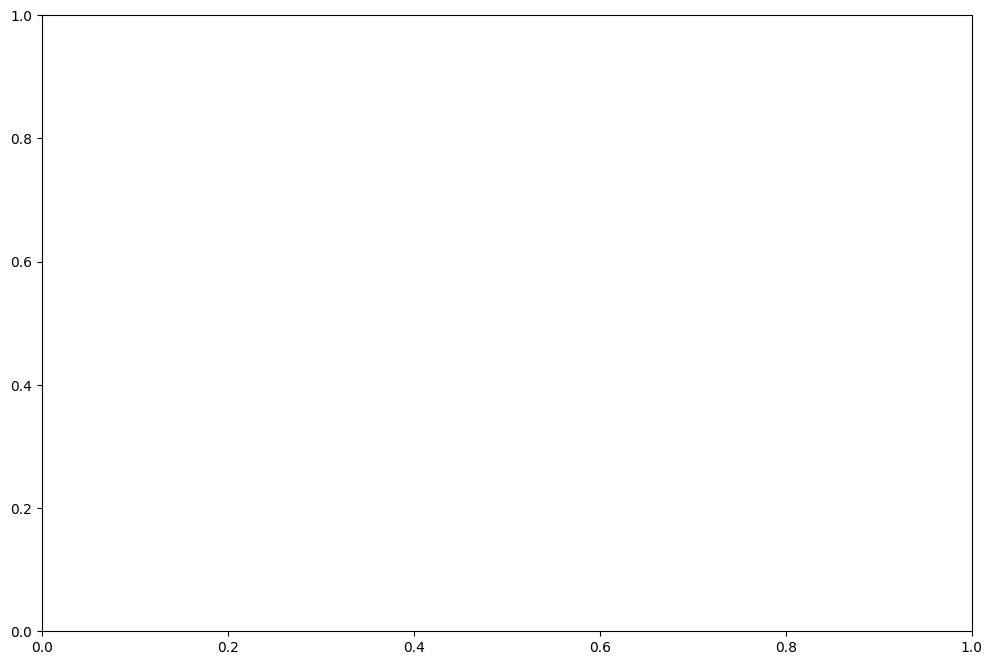

In [18]:
####################################
# plot final test loss against N
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

# Increase the width of the figure (e.g., 12 inches wide, 8 inches tall)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot for GMM
losses_gmm = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_gmm.keys()
for idx, key in enumerate(keys):
    losses_gmm[idx, :] = loss_dict_gmm[key]
losses_mean_gmm = torch.mean(losses_gmm, axis=0)
losses_std_gmm = torch.std(losses_gmm, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean_gmm,
    color='black',
    lw=3,
    label='GMM'
)

# Plot for GMM 1
losses_gmm1 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_gmm1.keys()
for idx, key in enumerate(keys):
    losses_gmm1[idx, :] = loss_dict_gmm1[key]
losses_mean_gmm1 = torch.mean(losses_gmm1, axis=0)
losses_std_gmm1 = torch.std(losses_gmm1, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean_gmm1,
    color='blue',
    lw=3,
    linestyle=':',  # dotted line
    label='GMM 1'
)

# Plot for GMM 2
losses_gmm2 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_gmm2.keys()
for idx, key in enumerate(keys):
    losses_gmm2[idx, :] = loss_dict_gmm2[key]
losses_mean_gmm2 = torch.mean(losses_gmm2, axis=0)
losses_std_gmm2 = torch.std(losses_gmm2, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean_gmm2,
    color='red',
    lw=3,
    linestyle=':',  # dotted line
    label='GMM 2'
)

# Plot for GMM 3
losses_gmm3 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_gmm3.keys()
for idx, key in enumerate(keys):
    losses_gmm3[idx, :] = loss_dict_gmm3[key]
losses_mean_gmm3 = torch.mean(losses_gmm3, axis=0)
losses_std_gmm3 = torch.std(losses_gmm3, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean_gmm3,
    color='green',
    lw=3,
    linestyle=':',  # dotted line
    label='GMM 3'
)

plt.ylabel('log(Loss)', fontsize=30)
plt.xlabel('Number of Layers/Steps', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width=3, length=10)
ax.tick_params(axis='both', which='minor', labelsize=20, width=3, length=5)

# Adjust legend properties to make it smaller and place it outside
ax.legend(
    fontsize=20,            # smaller font size for the legend
    loc='upper left',
    bbox_to_anchor=(1.05, 1.0),
    borderaxespad=0.,
    labelspacing=0.4,       # adjust space between legend entries
    handlelength=3          # length of the legend lines
)

# Use 'rect' in tight_layout to leave space on the right for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])  # 0.8 leaves some room on the right

plt.savefig(fig_dir + '/variable-L-plot.pdf', dpi=600)